# Julia is fast

Very often, benchmarks are used to compare languages.  These benchmarks can lead to long discussions, first as to exactly what is being benchmarked and secondly what explains the differences.  These simple questions can sometimes get more complicated than you at first might imagine.

The purpose of this notebook is for you to see a simple benchmark for yourself.  One can read the notebook and see what happened on the author's Macbook Pro with a 4-core Intel Core I7, or run the notebook yourself.

(This material began life as a wonderful lecture by Steven Johnson at MIT: https://github.com/stevengj/18S096/blob/master/lectures/lecture1/Boxes-and-registers.ipynb.)

# Outline of this notebook

- Define the sum function
- Implementations & benchmarking of sum in...
    - C (hand-written)
    - C (hand-written with -ffast-math)
    - python (built-in)
    - python (numpy)
    - python (hand-written)
    - Julia (built-in)
    - Julia (hand-written)
    - Julia (hand-written with SIMD)
- Summary of benchmarks

# `sum`: An easy enough function to understand

Consider the  **sum** function `sum(a)`, which computes
$$
\mathrm{sum}(a) = \sum_{i=1}^n a_i,
$$
where $n$ is the length of `a`.

In [1]:
a = rand(10^7) # 1D vector of random numbers, uniform on [0,1)

10000000-element Array{Float64,1}:
 0.26659008592419475
 0.1181232669043093
 0.5613625139993144
 0.15723166631690555
 0.022216506104875577
 0.3358286064083924
 0.12769923919685322
 0.41377105144440796
 0.8261792689041558
 0.013202456152695996
 0.367936543760194
 0.8556319050154402
 0.6699164063375578
 ⋮
 0.964628694920528
 0.027429466699048666
 0.33262848530091094
 0.7453337449343715
 0.7823336720187963
 0.7530989041245986
 0.1914823996270434
 0.3724674075157073
 0.8296829123864766
 0.16835643947772083
 0.21921471735594045
 0.006888276842752283

In [2]:
sum(a)

5.001318178950297e6

The expected result is 0.5 * 10^7, since the mean of each entry is 0.5

# Benchmarking a few ways in a few languages

In [3]:
@time sum(a)

  0.005644 seconds (1 allocation: 16 bytes)


5.001318178950297e6

In [4]:
@time sum(a)

  0.006394 seconds (1 allocation: 16 bytes)


5.001318178950297e6

In [5]:
@time sum(a)

  0.005849 seconds (1 allocation: 16 bytes)


5.001318178950297e6

The `@time` macro can yield noisy results, so it's not our best choice for benchmarking!

Luckily, Julia has a `BenchmarkTools.jl` package to make benchmarking easy and accurate:

In [6]:
using Pkg
Pkg.add("BenchmarkTools")

   Updating registry at `~/.julia/registries/General`
######################################################################### 100.0%
  Resolving package versions...
No Changes to `~/repos/JuliaAcademy/Introduction-to-Julia/Project.toml`
No Changes to `~/repos/JuliaAcademy/Introduction-to-Julia/Manifest.toml`


In [7]:
using BenchmarkTools

┌ Info: Precompiling BenchmarkTools [6e4b80f9-dd63-53aa-95a3-0cdb28fa8baf]
└ @ Base loading.jl:1278


#  1. The C language

C is often considered the gold standard: difficult on the human, nice for the machine. Getting within a factor of 2 of C is often satisfying. Nonetheless, even within C, there are many kinds of optimizations possible that a naive C writer may or may not get the advantage of.

The current author does not speak C, so he does not read the cell below, but is happy to know that you can put C code in a Julia session, compile it, and run it. Note that the `"""` wrap a multi-line string.

In [8]:
using Libdl
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file


# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc -fPIC -O3 -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum (generic function with 1 method)

In [9]:
c_sum(a)

5.001318178950161e6

In [10]:
c_sum(a) ≈ sum(a) # type \approx and then <TAB> to get the ≈ symbolb

true

In [11]:
c_sum(a) - sum(a)  

-1.3597309589385986e-7

In [13]:
≈  # alias for the `isapprox` function

isapprox (generic function with 9 methods)

In [14]:
?isapprox

search: isapprox



```
isapprox(x, y; rtol::Real=atol>0 ? 0 : √eps, atol::Real=0, nans::Bool=false, norm::Function)
```

Inexact equality comparison: `true` if `norm(x-y) <= max(atol, rtol*max(norm(x), norm(y)))`. The default `atol` is zero and the default `rtol` depends on the types of `x` and `y`. The keyword argument `nans` determines whether or not NaN values are considered equal (defaults to false).

For real or complex floating-point values, if an `atol > 0` is not specified, `rtol` defaults to the square root of [`eps`](@ref) of the type of `x` or `y`, whichever is bigger (least precise). This corresponds to requiring equality of about half of the significand digits. Otherwise, e.g. for integer arguments or if an `atol > 0` is supplied, `rtol` defaults to zero.

`x` and `y` may also be arrays of numbers, in which case `norm` defaults to the usual `norm` function in LinearAlgebra, but may be changed by passing a `norm::Function` keyword argument. (For numbers, `norm` is the same thing as `abs`.) When `x` and `y` are arrays, if `norm(x-y)` is not finite (i.e. `±Inf` or `NaN`), the comparison falls back to checking whether all elements of `x` and `y` are approximately equal component-wise.

The binary operator `≈` is equivalent to `isapprox` with the default arguments, and `x ≉ y` is equivalent to `!isapprox(x,y)`.

Note that `x ≈ 0` (i.e., comparing to zero with the default tolerances) is equivalent to `x == 0` since the default `atol` is `0`.  In such cases, you should either supply an appropriate `atol` (or use `norm(x) ≤ atol`) or rearrange your code (e.g. use `x ≈ y` rather than `x - y ≈ 0`).   It is not possible to pick a nonzero `atol` automatically because it depends on the overall scaling (the "units") of your problem: for example, in `x - y ≈ 0`, `atol=1e-9` is an absurdly small tolerance if `x` is the [radius of the Earth](https://en.wikipedia.org/wiki/Earth_radius) in meters, but an absurdly large tolerance if `x` is the [radius of a Hydrogen atom](https://en.wikipedia.org/wiki/Bohr_radius) in meters.

# Examples

```jldoctest
julia> 0.1 ≈ (0.1 - 1e-10)
true

julia> isapprox(10, 11; atol = 2)
true

julia> isapprox([10.0^9, 1.0], [10.0^9, 2.0])
true

julia> 1e-10 ≈ 0
false

julia> isapprox(1e-10, 0, atol=1e-8)
true
```

---

```
isapprox(x; kwargs...) / ≈(x; kwargs...)
```

Create a function that compares its argument to `x` using `≈`, i.e. a function equivalent to `y -> y ≈ x`.

The keyword arguments supported here are the same as those in the 2-argument `isapprox`.


We can now benchmark the C code directly from Julia:

In [15]:
c_bench = @benchmark c_sum($a)

BenchmarkTools.Trial: 619 samples with 1 evaluation.
 Range (min … max):  7.600 ms …   9.126 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     8.045 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   8.076 ms ± 261.294 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

        ▃▂▂▁▄▄▃ ▃▅█ ▆▃▃▁▅▃▁▄▂▃▂▇    ▁     ▁                    
  ▃▃▅▄▅████████▇█████████████████▆▅██▇▆█▇▆█▅▄▄▃▃▃▅▇▅▅▃▃▃▃▃▃▁▄ ▅
  7.6 ms          Histogram: frequency by time        8.79 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [16]:
println("C: Fastest time was $(minimum(c_bench.times) / 1e6) msec")

C: Fastest time was 7.599957 msec


In [17]:
d = Dict()  # a "dictionary", i.e. an associative array
d["C"] = minimum(c_bench.times) / 1e6  # in milliseconds
d

Dict{Any,Any} with 1 entry:
  "C" => 7.59996

In [18]:
using Plots
gr()

Plots.GRBackend()

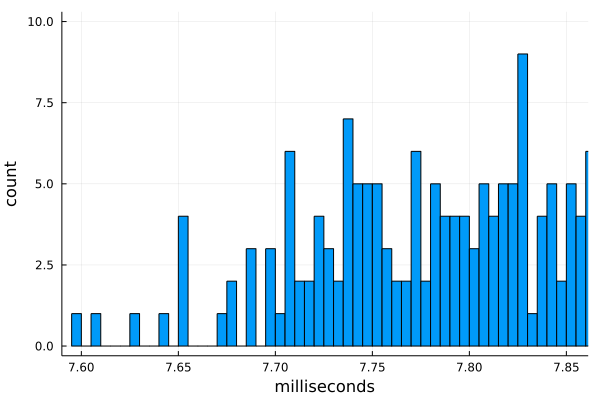

In [19]:
using Statistics # bring in statistical support for standard deviations
t = c_bench.times / 1e6 # times in milliseconds
m, σ = minimum(t), std(t)

histogram(t, bins=500,
    xlim=(m - 0.01, m + σ),
    xlabel="milliseconds", ylabel="count", label="")

# 2. C with -ffast-math

If we allow C to re-arrange the floating point operations, then it'll vectorize with SIMD (single instruction, multiple data) instructions.

In [20]:
const Clib_fastmath = tempname()   # make a temporary file

# The same as above but with a -ffast-math flag added
open(`gcc -fPIC -O3 -msse3 -xc -shared -ffast-math -o $(Clib_fastmath * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum_fastmath(X::Array{Float64}) = ccall(("c_sum", Clib_fastmath), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum_fastmath (generic function with 1 method)

In [21]:
c_fastmath_bench = @benchmark $c_sum_fastmath($a)

BenchmarkTools.Trial: 1185 samples with 1 evaluation.
 Range (min … max):  3.664 ms …   6.485 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     4.164 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   4.206 ms ± 260.228 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

                 ▃▄▆▄▄▅▆█▄▅▁▃▂▂ ▁▁                             
  ▃▄▄▃▅▃▅▄▃▅▅▆▇▅██████████████████▆█▇▅▆▅▅▄▅▆▅▅▄▃▃▄▃▂▃▃▄▃▃▂▂▁▂ ▄
  3.66 ms         Histogram: frequency by time        4.94 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [22]:
d["C -ffast-math"] = minimum(c_fastmath_bench.times) / 1e6  # in milliseconds

3.663853

# 3. Python's built in `sum` 

The `PyCall` package provides a Julia interface to Python:

In [23]:
using Pkg; Pkg.add("PyCall")
using PyCall

  Resolving package versions...
No Changes to `~/repos/JuliaAcademy/Introduction-to-Julia/Project.toml`
No Changes to `~/repos/JuliaAcademy/Introduction-to-Julia/Manifest.toml`
┌ Info: Precompiling PyCall [438e738f-606a-5dbb-bf0a-cddfbfd45ab0]
└ @ Base loading.jl:1278


In [24]:
# get the Python built-in "sum" function:
pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [25]:
pysum(a)

5.001318178950161e6

In [26]:
pysum(a) ≈ sum(a)

true

In [27]:
py_list_bench = @benchmark $pysum($a)

BenchmarkTools.Trial: 6 samples with 1 evaluation.
 Range (min … max):  795.672 ms …    1.059 s  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):        1.014 s               ┊ GC (median):    0.00%
 Time  (mean ± σ):   954.366 ms ± 119.549 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▁  ▁                                          ▁        █    ▁  
  █▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁█▁▁▁▁█ ▁
  796 ms           Histogram: frequency by time          1.06 s <

 Memory estimate: 336 bytes, allocs estimate: 6.

In [28]:
d["Python built-in"] = minimum(py_list_bench.times) / 1e6
d

Dict{Any,Any} with 3 entries:
  "C"               => 7.59996
  "Python built-in" => 795.672
  "C -ffast-math"   => 3.66385

# 4. Python: `numpy` 

## Takes advantage of hardware "SIMD", but only works when it works.

`numpy` is an optimized C library, callable from Python.
It may be installed within Julia as follows:

In [29]:
using Pkg; Pkg.add("Conda")
using Conda

  Resolving package versions...
No Changes to `~/repos/JuliaAcademy/Introduction-to-Julia/Project.toml`
No Changes to `~/repos/JuliaAcademy/Introduction-to-Julia/Manifest.toml`


In [30]:
Conda.add("numpy")

┌ Info: Running `conda install -y numpy` in root environment
└ @ Conda /Users/diemilio/.julia/packages/Conda/1403Y/src/Conda.jl:129


Solving environment: ...working... done

# All requested packages already installed.



In [31]:
numpy_sum = pyimport("numpy")["sum"]

py_numpy_bench = @benchmark $numpy_sum($a)

BenchmarkTools.Trial: 1045 samples with 1 evaluation.
 Range (min … max):  3.900 ms … 49.242 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     4.487 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   4.770 ms ±  1.981 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ▁▄▅█▄▃▁                                                    
  ▅████████▆▄▄▄▃▃▂▃▂▂▁▂▂▂▁▂▂▂▂▂▁▁▁▁▁▂▂▁▁▂▂▁▁▁▁▁▂▁▁▁▁▁▂▂▁▁▂▁▂ ▃
  3.9 ms         Histogram: frequency by time        10.6 ms <

 Memory estimate: 336 bytes, allocs estimate: 6.

In [32]:
numpy_sum(a)

5.00131817895029e6

In [33]:
numpy_sum(a) ≈ sum(a)

true

In [34]:
d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

Dict{Any,Any} with 4 entries:
  "C"               => 7.59996
  "Python numpy"    => 3.90023
  "Python built-in" => 795.672
  "C -ffast-math"   => 3.66385

# 5. Python, hand-written 

In [35]:
py"""
def py_sum(A):
    s = 0.0
    for a in A:
        s += a
    return s
"""

sum_py = py"py_sum"

PyObject <function py_sum at 0x7fa99929d040>

In [36]:
py_hand = @benchmark $sum_py($a)

BenchmarkTools.Trial: 5 samples with 1 evaluation.
 Range (min … max):  967.071 ms …    1.365 s  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):        1.095 s               ┊ GC (median):    0.00%
 Time  (mean ± σ):      1.103 s ± 161.704 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █                  ▁  ▁                                     ▁  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  967 ms           Histogram: frequency by time          1.37 s <

 Memory estimate: 336 bytes, allocs estimate: 6.

In [37]:
sum_py(a)

5.001318178950161e6

In [38]:
sum_py(a) ≈ sum(a)

true

In [39]:
d["Python hand-written"] = minimum(py_hand.times) / 1e6
d

Dict{Any,Any} with 5 entries:
  "C"                   => 7.59996
  "Python numpy"        => 3.90023
  "Python hand-written" => 967.071
  "Python built-in"     => 795.672
  "C -ffast-math"       => 3.66385

# 6. Julia (built-in) 

## Written directly in Julia, not in C!

In [40]:
@which sum(a)

sum(a::AbstractArray; dims) in Base at reducedim.jl:722

In [41]:
j_bench = @benchmark sum($a)

BenchmarkTools.Trial: 1238 samples with 1 evaluation.
 Range (min … max):  3.798 ms …   5.912 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     3.996 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   4.023 ms ± 152.596 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

          ▁▄▄▅▅▆█▆▇▄▅▃▃▃▁                                      
  ▃▅▆▆▆█▆████████████████▇█▇▆▄█▅▅▆▄▃▄▄▃▃▃▃▃▃▁▂▃▃▁▂▃▃▂▂▁▁▁▂▃▂▂ ▄
  3.8 ms          Histogram: frequency by time        4.52 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [42]:
d["Julia built-in"] = minimum(j_bench.times) / 1e6
d

Dict{Any,Any} with 6 entries:
  "C"                   => 7.59996
  "Python numpy"        => 3.90023
  "Python hand-written" => 967.071
  "Python built-in"     => 795.672
  "Julia built-in"      => 3.79775
  "C -ffast-math"       => 3.66385

# 7. Julia (hand-written) 

In [43]:
function mysum(A)   
    s = 0.0 # s = zero(eltype(a))
    for a in A
        s += a
    end
    s
end

mysum (generic function with 1 method)

In [44]:
j_bench_hand = @benchmark mysum($a)

BenchmarkTools.Trial: 570 samples with 1 evaluation.
 Range (min … max):  7.798 ms …  10.443 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     8.716 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   8.754 ms ± 346.328 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

                     ▂▃▅▇▆▇█▃▅▅▄▃▃▁                            
  ▃▂▁▁▂▃▃▃▄▂▄▃▅▄▄▅▅▄▇██████████████▇▆▅▅▃▄▃▁▄▂▃▅▃▂▂▁▃▃▂▂▂▃▁▂▃▃ ▄
  7.8 ms          Histogram: frequency by time         9.9 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [45]:
d["Julia hand-written"] = minimum(j_bench_hand.times) / 1e6
d

Dict{Any,Any} with 7 entries:
  "C"                   => 7.59996
  "Python numpy"        => 3.90023
  "Julia hand-written"  => 7.7982
  "Python hand-written" => 967.071
  "Python built-in"     => 795.672
  "Julia built-in"      => 3.79775
  "C -ffast-math"       => 3.66385

# 8. Julia (hand-written w. simd) 

In [46]:
function mysum_simd(A)   
    s = 0.0 # s = zero(eltype(A))
    @simd for a in A
        s += a
    end
    s
end

mysum_simd (generic function with 1 method)

In [47]:
j_bench_hand_simd = @benchmark mysum_simd($a)

BenchmarkTools.Trial: 1253 samples with 1 evaluation.
 Range (min … max):  3.775 ms …   6.039 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     3.906 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   3.976 ms ± 227.973 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▃▆▄▆▇█▇▇▃                                                    
  ███████████▇▆▅▅▅▅▄▅▃▃▄▄▄▄▃▃▄▃▂▃▃▂▃▃▂▃▂▂▂▃▂▂▃▁▁▂▂▂▂▂▂▁▂▂▂▂▁▂ ▄
  3.78 ms         Histogram: frequency by time        4.86 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [48]:
mysum_simd(a)

5.00131817895028e6

In [49]:
d["Julia hand-written simd"] = minimum(j_bench_hand_simd.times) / 1e6
d

Dict{Any,Any} with 8 entries:
  "Julia hand-written simd" => 3.77507
  "C"                       => 7.59996
  "Python numpy"            => 3.90023
  "Julia hand-written"      => 7.7982
  "Python hand-written"     => 967.071
  "Python built-in"         => 795.672
  "Julia built-in"          => 3.79775
  "C -ffast-math"           => 3.66385

# Summary

In [50]:
for (key, value) in sort(collect(d), by=last)
    println(rpad(key, 25, "."), lpad(round(value; digits=1), 6, "."))
end

C -ffast-math...............3.7
Julia hand-written simd.....3.8
Julia built-in..............3.8
Python numpy................3.9
C...........................7.6
Julia hand-written..........7.8
Python built-in...........795.7
Python hand-written.......967.1
